## Reference

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://pytorch.org/vision/stable/transforms.html

## Libraries

In [41]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from sklearn.metrics import classification_report

# Tracking progress
from tqdm import tqdm

# Set Seed
torch.manual_seed(2021)

plt.ion()   # interactive mode

## Load Data

In [2]:
# Just normalization for validation
data_transforms = {
    'mini': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/home/ubuntu/data/2A_images_reorg'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['mini', 'val', 'test']}
        
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['mini', 'val', 'test']}
        
dataset_sizes = {x: len(image_datasets[x]) for x in ['mini', 'val', 'test']}
class_names = image_datasets['mini'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset_sizes

## Sample Image

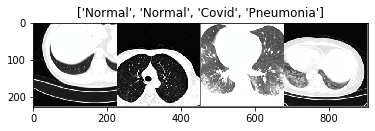

In [3]:
def imshow(inp, title=None):   
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['mini']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Model Function

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'epoch':[],'train_loss':[],'train_acc':[],"val_loss":[],'val_acc':[]}

    for epoch in tqdm(range(num_epochs), position=0, leave=True):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        history['epoch'].append(epoch)

        # Each epoch has a training and validation phase
        for phase in ['mini', 'val']:
            if phase == 'mini':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'mini'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'mini':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'mini':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # store statistics
            if phase == 'mini':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

Visual Model Predictions

In [35]:
def visualize_model(model, num_images=6, pred_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    eval_history = {'predict':[], 'actual':[]}

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                if images_so_far <= num_images:
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title('(predicted,actual): ({0},{1})'.format(class_names[preds[j]], class_names[labels[j]]))
                    imshow(inputs.cpu().data[j])

                    eval_history['predict'].append(class_names[preds[j]])
                    eval_history['actual'].append(class_names[labels[j]])
                
                elif images_so_far < pred_images:
                    eval_history['predict'].append(class_names[preds[j]])
                    eval_history['actual'].append(class_names[labels[j]])
                    
                elif images_so_far == pred_images:
                    model.train(mode=was_training)
                    return eval_history
        model.train(mode=was_training)

## Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
models.resnet18(pretrained=True)

## Train and evaluate
Takes about 15 minutes for 10 epochs

In [ ]:
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9
----------
mini Loss: 0.2411 Acc: 0.9207


 10%|█         | 1/10 [01:25<12:51, 85.72s/it]

val Loss: 0.0892 Acc: 0.9685

Epoch 1/9
----------
mini Loss: 0.2175 Acc: 0.9280


 20%|██        | 2/10 [02:51<11:25, 85.63s/it]

val Loss: 0.0900 Acc: 0.9740

Epoch 2/9
----------
mini Loss: 0.1453 Acc: 0.9501


 30%|███       | 3/10 [04:16<09:59, 85.64s/it]

val Loss: 0.0581 Acc: 0.9815

Epoch 3/9
----------
mini Loss: 0.1241 Acc: 0.9583


 40%|████      | 4/10 [05:42<08:34, 85.70s/it]

val Loss: 0.0529 Acc: 0.9837

Epoch 4/9
----------
mini Loss: 0.1118 Acc: 0.9609


 50%|█████     | 5/10 [07:08<07:09, 85.81s/it]

val Loss: 0.0494 Acc: 0.9847

Epoch 5/9
----------
mini Loss: 0.1203 Acc: 0.9613


 60%|██████    | 6/10 [08:34<05:43, 85.80s/it]

val Loss: 0.0511 Acc: 0.9842

Epoch 6/9
----------
mini Loss: 0.1123 Acc: 0.9619


 70%|███████   | 7/10 [10:01<04:18, 86.17s/it]

val Loss: 0.0486 Acc: 0.9852

Epoch 7/9
----------
mini Loss: 0.1136 Acc: 0.9620


 80%|████████  | 8/10 [11:28<02:52, 86.29s/it]

val Loss: 0.0462 Acc: 0.9865

Epoch 8/9
----------
mini Loss: 0.1102 Acc: 0.9633


 90%|█████████ | 9/10 [12:54<01:26, 86.28s/it]

val Loss: 0.0476 Acc: 0.9852

Epoch 9/9
----------


## Model Performance

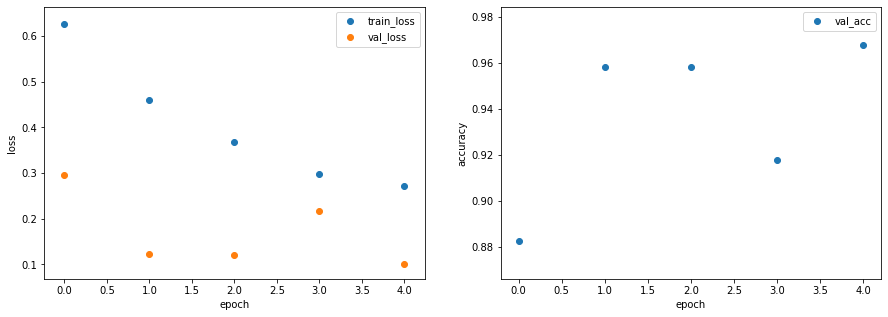

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].scatter(x=history['epoch'], y=history['train_loss'], label='train_loss')
ax[0].scatter(x=history['epoch'], y=history['val_loss'], label='val_loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].scatter(x=history['epoch'], y=history['val_acc'], label='val_acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()

## Visualize Model Output

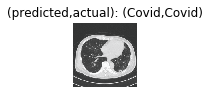

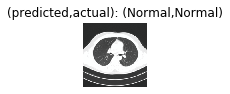

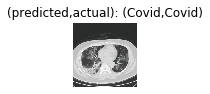

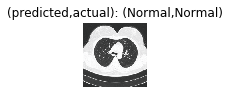

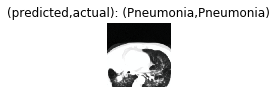

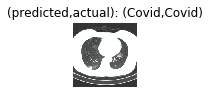

In [38]:
eval_history = visualize_model(model_ft, num_images=6, pred_images=100)

In [46]:
print(classification_report(eval_history['actual'], eval_history['predict']))

              precision    recall  f1-score   support

       Covid       0.91      0.91      0.91        47
      Normal       0.88      1.00      0.93        28
   Pneumonia       1.00      0.83      0.91        24

    accuracy                           0.92        99
   macro avg       0.93      0.92      0.92        99
weighted avg       0.92      0.92      0.92        99

